## Exporting necessary libraries

In [11]:
# Import necessary libraries
import os
import ast
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from dotenv import load_dotenv
from tqdm import trange
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


# Import libraries for working with language models and Google Gemini
from langchain_openai import ChatOpenAI, OpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold

# Install the google-generativeai package (uncomment the line below to run the installation)
!pip install -U -q google-generativeai

# Set up the environment for plotting
%matplotlib inline

# Load environment variables
load_dotenv()
GEMINI_KEY = os.environ.get('GEMINI_KEY')
genai.configure(api_key=GEMINI_KEY)

/Users/jerryyang/Desktop/SPH/sph-timeline-project/timeline/bin/pip: line 2: /home/jerry/Desktop/timeline project/timeline/bin/python3: No such file or directory
/Users/jerryyang/Desktop/SPH/sph-timeline-project/timeline/bin/pip: line 2: exec: /home/jerry/Desktop/timeline project/timeline/bin/python3: cannot execute: No such file or directory


## Load and Combine JSON files

In [56]:
def combine_json(files):
    combined_data = []
    for file in files:
        with open(file, 'r') as f:
            # Load data from the file and append it to the combined list
            data = json.load(f)
            combined_data.extend(data)
    return combined_data

# Example usage
files = ['../data_upload/final_db1.json', '../data_upload/final_db2.json', '../data_upload/final_db3.json', '../data_upload/final_db4.json']
db = combine_json(files)

In [57]:
def read_load_json(json_data):
    for item in json_data:
        #Convert the embeddings to json string as CSVs dont accept list as a data type
        item['tags_embeddings'] = json.dumps(item['tags_embeddings'])
        item['Title_embeddings'] = json.dumps(item['Title_embeddings'])
    df = pd.DataFrame(json_data)
    return df

In [58]:
df = read_load_json(db)
df.head()

,id,Text,Title,embeddings,combined,tags,tags_embeddings,Title_embeddings,Publication_date
0,nos7tzp7jprxlqxe,GENEVA – The remains of a climber discovered i...,Remains found in Swiss Alps are those of Briti...,"[0.063923, 0.065677, -0.001089, 0.065425, -0.0...",Title: Remains found in Swiss Alps are those o...,"[Missing Climber, Swiss Alps, Glaciers, Global...","[0.025687463581562042, 0.03274165466427803, -0...","[0.021028, 0.006548, 0.037958, 0.049163, -0.00...",2023-09-01
1,zvv4ue0w64vfqoz1,Ms Greta Thunburg became a household name when...,Involve youth in shaping ethical use of AI,"[0.063668, 0.098002, -0.022514, -0.033031, -0....",Title: Involve youth in shaping ethical use of...,"[Youth activism, Artificial intelligence, Ethi...","[0.026038197800517082, 0.05095928534865379, -0...","[0.033077, 0.121931, -0.034714, 0.012957, -0.0...",2023-09-02
2,aph1tgua3xxoq2sg,NEW YORK - Defending women's champion Iga...,"Swiatek, Djokovic headline third round action ...","[-0.019315, 0.066645, 0.009547, 0.029555, -0.0...","Title: Swiatek, Djokovic headline third round ...","[US Open, Grand Slam, Novak Djokovic, Iga Swia...","[-0.04092131927609444, 0.015564153902232647, -...","[-0.018808, -0.049826, 0.005458, -0.010391, -0...",2023-09-01
3,rlh53czyst054zfn,JAKARTA – Hopes of a return to democracy in ju...,‘Systematic repression’ crushing Myanmar’s dem...,"[0.067328, -0.004407, 0.010127, -0.004268, -0....",Title: ‘Systematic repression’ crushing Myanma...,"[Myanmar, UN chief, ASEAN, Rohingya, Military ...","[0.02929660677909851, 0.0006651841104030609, -...","[0.059998, -0.014698, 0.02184, -0.031714, 0.00...",2023-09-07
4,aksixz7uun2gkpss,JERUSALEM - Israel's shekel dropped to it...,Israel's shekel falls as judicial showdown looms,"[-0.043186, 0.076352, -0.015492, -0.02859, -0....",Title: Israel's shekel falls as judicial showd...,"[Israel, Shekel, Judicial crisis, Supreme Cour...","[0.015406888909637928, 0.04966922104358673, 0....","[-0.02634, 0.070879, 0.013255, -0.008821, -0.0...",2023-09-07


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2008 non-null   object
 1   Text              2008 non-null   object
 2   Title             2007 non-null   object
 3   embeddings        2008 non-null   object
 4   combined          2007 non-null   object
 5   tags              2008 non-null   object
 6   tags_embeddings   2008 non-null   object
 7   Title_embeddings  2008 non-null   object
 8   Publication_date  2008 non-null   object
dtypes: object(9)
memory usage: 141.3+ KB


## Data Preprocessing 
- Concatentation of embeddings
- Standardisation of embeddings

In [59]:
# Deserialising of embeddings
body_embeddings= np.array(df['embeddings'].apply(ast.literal_eval).tolist())
title_embeddings= np.array(df['Title_embeddings'].apply(ast.literal_eval).tolist())
tags_embeddings= np.array(df['tags_embeddings'].apply(ast.literal_eval).tolist())
body_embeddings.shape

(2008, 768)

In [62]:
#Standardisation of embeddings
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit and transform each embedding set
article_embeddings_normalized = scaler.fit_transform(body_embeddings)
title_embeddings_normalized = scaler.fit_transform(title_embeddings)
tags_embeddings_normalized = scaler.fit_transform(tags_embeddings)

In [63]:
# Combine embeddings
all_embeddings = np.concatenate((article_embeddings_normalized, title_embeddings_normalized, tags_embeddings_normalized), axis=1)  
all_embeddings.shape

(2008, 2304)

In [68]:
from sklearn.model_selection import train_test_split

#Use 90:10 ratio
train_embeddings, test_embeddings = train_test_split(all_embeddings, test_size=0.1, random_state=42)

## Conducting PCA Experimentation to find best amount of variance.

# For threshold 95%

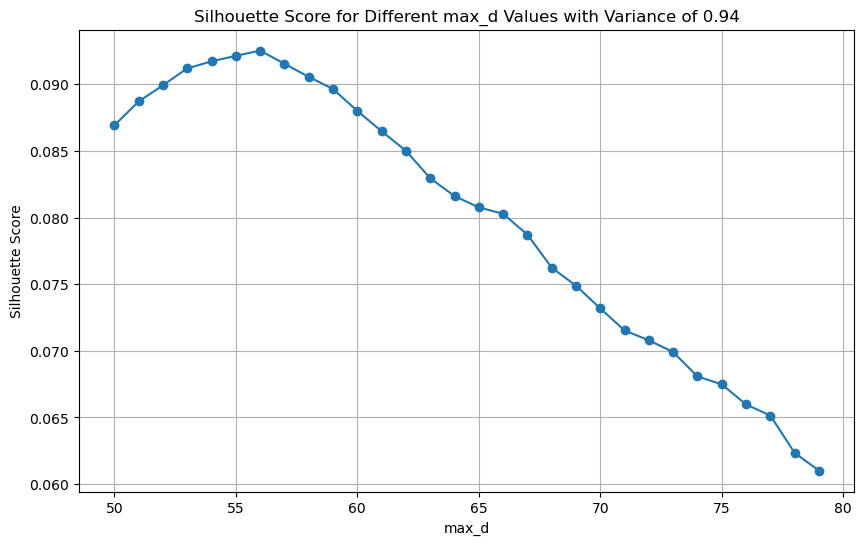

0.94 variance has the best max_d: 56 with Silhouette Score: 0.09252519058398952


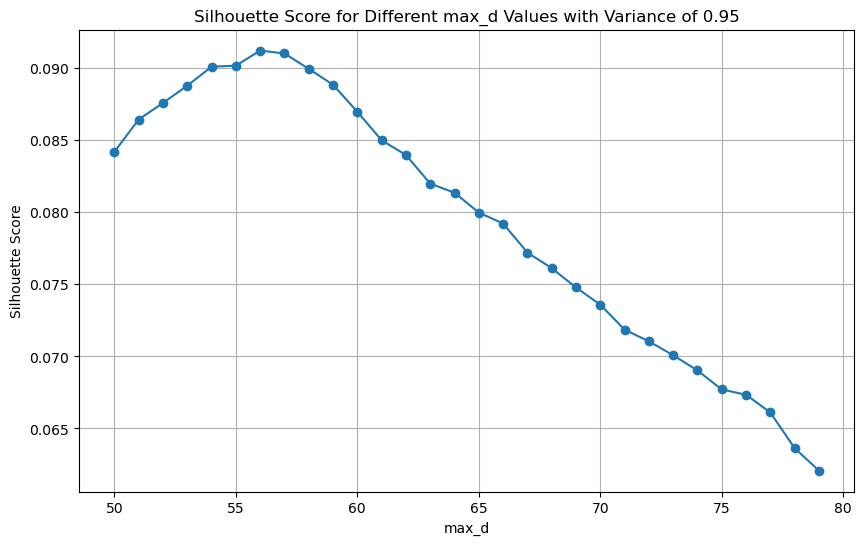

0.95 variance has the best max_d: 56 with Silhouette Score: 0.09119801413843136


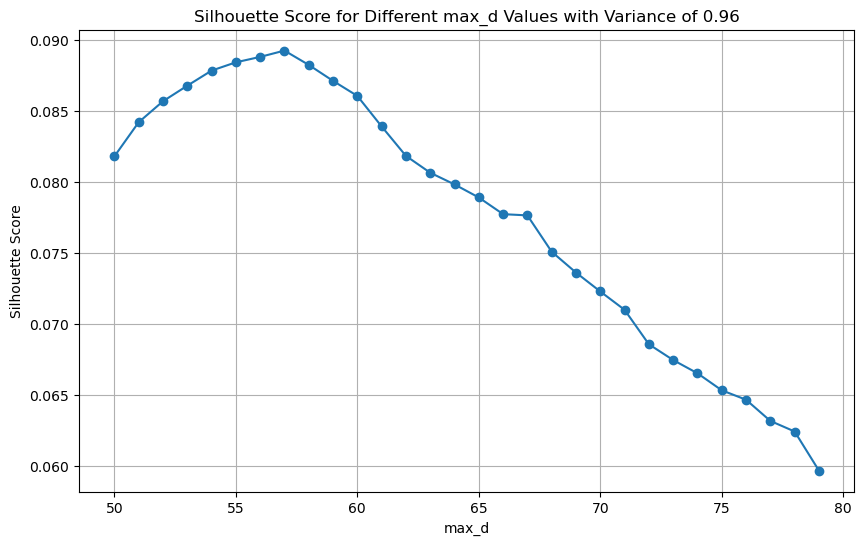

0.96 variance has the best max_d: 57 with Silhouette Score: 0.08923308393195549


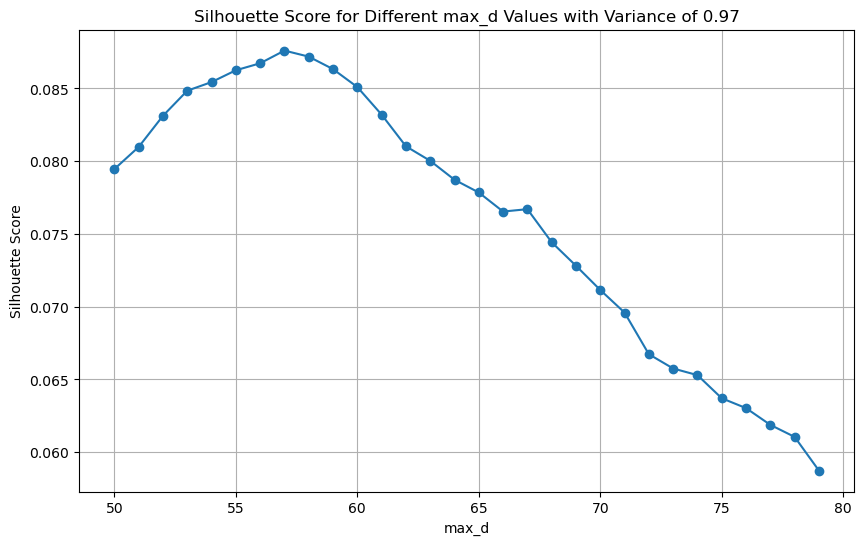

0.97 variance has the best max_d: 57 with Silhouette Score: 0.08760252822632376
{0.94: {'max_d': 56, 'silhouette': 0.09252519058398952}, 0.95: {'max_d': 56, 'silhouette': 0.09119801413843136}, 0.96: {'max_d': 57, 'silhouette': 0.08923308393195549}, 0.97: {'max_d': 57, 'silhouette': 0.08760252822632376}}


In [84]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster

# Experiment for this variance range of 92% to 97%
variance_range = list(np.arange(0.92, 0.97, 0.01))

variance_perf = {}

for variance in variance_range:
    pca = PCA(n_components=variance)
    train_pca_embeddings = pca.fit_transform(train_embeddings)
    test_pca_embeddings = pca.transform(test_embeddings)
    
    # Range of max_d values to try
    max_d_values = np.arange(50,80)

    # Dictionary to store silhouette scores
    silhouette_scores = []

    # Perform hierarchical clustering and evaluate silhouette scores
    Z = linkage(train_pca_embeddings, method='ward')

    for max_d in max_d_values:
        clusters = fcluster(Z, max_d, criterion='distance')
        score = silhouette_score(train_pca_embeddings, clusters)
        silhouette_scores.append(score)

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(max_d_values, silhouette_scores, marker='o')
    plt.xlabel('max_d')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score for Different max_d Values with Variance of {variance}')
    plt.grid(True)
    plt.show()

    # Determine the best max_d
    best_max_d = max_d_values[np.argmax(silhouette_scores)]
    variance_perf[variance] = {'max_d': best_max_d, 'best_silhouette': max(silhouette_scores)}
    print(f'{variance} variance has the best max_d: {best_max_d} with Silhouette Score: {max(silhouette_scores)}')

print(variance_perf)

In [85]:
variance_perf

{0.94: {'max_d': 56, 'silhouette': 0.09252519058398952},
 0.95: {'max_d': 56, 'silhouette': 0.09119801413843136},
 0.96: {'max_d': 57, 'silhouette': 0.08923308393195549},
 0.97: {'max_d': 57, 'silhouette': 0.08760252822632376}}

In [86]:
# Find the best variance and its corresponding silhouette score
best_params = []
max_silhouette = 0
for variance, params in variance_perf.items():
    if params['best_silhouette'] > max_silhouette:
        max_silhouette = params['best_silhouette']
        best_params.append((variance, params['max_d']))
best_params = best_params[-1]
best_params

(0.94, 56)

In [86]:
llm = genai.GenerativeModel('gemini-1.0-pro')

template = '''
            Write a concise summary of the following news article and return your response which covers the key points and events described in the article.\
            The generated summary should not include contractions.\
            TEXT: {text}\
            SUMMARY
            '''

prompt = PromptTemplate(
        input_variables=["text"],
        template=template,
    )

combined_articles = list(df_clusters.values)

summaries = []


def fetch_summary(article):
    article = combined_articles[i]
    final_prompt  = prompt.format(text=article)
    summary = llm.generate_content(final_prompt,
                                   safety_settings={
                                    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                                    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                                    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE, 
                                    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
                                    }
    )
    time.sleep(1)
    try:
        return summary.text
    except ValueError:
        return summary.prompt_feedback

def process_articles(df, max_workers=10):
    results = {}
    batch_size = 10
    cooldown_period = 10  

    articles = df['combined'].tolist()
    ids = df['id'].tolist()
    article_id_pairs = list(zip(articles, ids))

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for i in range(0, len(article_id_pairs), batch_size):
            current_batch = article_id_pairs[i:i+batch_size]
            print(f"Starting batch processing for articles {i+1} to {min(i+batch_size, len(article_id_pairs))}")
            futures = {executor.submit(fetch_summary, pair): pair for pair in current_batch}

            processed_count = i
            for future in as_completed(futures):
                article_id, summary = future.result()
                results[article_id] = summary
                processed_count += 1
                print(f"Processed {processed_count}")

            if processed_count >= len(article_id_pairs):
                return results

            print(f"All tasks in batch {i//batch_size + 1} completed, cooling down for {cooldown_period} seconds...")
            time.sleep(cooldown_period)
    return results

summaries = process_articles(df)

100%|██████████| 54/54 [02:51<00:00,  3.18s/it]


In [ ]:
df_clusters["Summary_text"] = pd.DataFrame(summaries)
df_clusters["Combined"] = "Title: " + df_clusters.Title.str.strip() + "; Summary: " + df_clusters.Summary_text.str.strip()
template = '''

Task Description: Analyze the provided summaries and titles from a single cluster of articles. 
Your task is to generate a concise theme or label that best captures the commonality across these articles. 
The theme should be broad yet descriptive, following the format shown in the examples below.

Examples:
Combined Title and Summaries: "Hurricane Eta causes widespread destruction across Central America; Governments struggle to provide aid amid pandemic; Environmentalists highlight increased hurricane activity due to climate change."
Cluster Label: Crises and Disasters
Combined Title and Summaries: "Record-breaking temperatures reported globally; Scientists link extreme weather to climate change; Policy makers discuss carbon neutral targets at international summit."
Cluster Label:Environmental Challenges and Climate Action
Your Input:

Combined Title and Summaries:
{text}
Cluster Label:
'''

prompt = PromptTemplate(
    input_variables=["text"],
    template=template)

common_themes = []
for i in trange(n_clusters):
    cluster_i_combined = df_clusters[df_clusters['Cluster Number'] == i]
    combined_title_summary = '\n'.join(list(cluster_i_combined.Combined.values))
    final_prompt  = prompt.format(text=combined_title_summary)
    common_theme = llm.generate_content(final_prompt)
    common_themes.append(common_theme.text)

In [87]:
summaries

["In the season-opening Giant Slalom World Cup, Switzerland's Lara Gut-Behrami triumphed by a narrow margin over Italy's Federica Brignone. Despite a mediocre first run, Gut-Behrami's exceptional second run propelled her to victory. Favorite Mikaela Shiffrin of the US finished in sixth place. Petra Vlhova of Slovakia secured third position overall.",
 "Singapore defeated the Cook Islands 58-36 in the Nations Cup netball match. Despite an initial tie, Singapore dominated throughout the game, leading 20-13 in the first quarter and extending their advantage to 32-19 by halftime. Singapore maintained their dominance in the second half, widening the gap to 47-26 after three quarters. Goal shooter Amandeep Kaur Chahal's 91% shot conversion rate played a significant role in Singapore's victory. The Cook Islands, a mix of experienced and developing players, acknowledged Singapore's exploitation of their unforced errors and poor decision-making. Singapore coach Annette Bishop highlighted the im